1️⃣ Collocation phrase 사전 만들기

👉 4-gram 중심 + 3-gram 보조

📌 역할
	•	“정책 문구 덩어리”를 하나의 토큰으로 만들 준비

In [1]:
import pandas as pd

# 사용할 collocation clean 파일
fourgram = pd.read_csv('fourgram_col_clean.csv')
trigram  = pd.read_csv('trigram_col_clean.csv')

# 상위 N개만 사용 (실무적으로 안정적인 범위)
FOURGRAM_TOP = 1200
TRIGRAM_TOP  = 600

four_phrases = fourgram.sort_values(
    ['freq', 'pmi'], ascending=[False, False]
).head(FOURGRAM_TOP)['ngram'].tolist()

three_phrases = trigram.sort_values(
    ['freq', 'pmi'], ascending=[False, False]
).head(TRIGRAM_TOP)['ngram'].tolist()

# 길이 긴 것부터 치환해야 깨짐 방지
phrase_list = sorted(
    set(four_phrases + three_phrases),
    key=lambda x: -len(x.split())
)

print('total phrases :', len(phrase_list))

total phrases : 1800


In [2]:
import pandas as pd

df = pd.read_csv('df_master_TM_proj_lemma.csv')

2️⃣ Phrase를 텍스트에 적용 (underscore 치환)

📌 역할
	•	federal open market committee
→ federal_open_market_committee
	•	토픽모델이 의미 단위로 학습 가능

In [3]:
def apply_phrases(text, phrases):
    if pd.isna(text):
        return text

    out = text
    for p in phrases:
        token = p.replace(' ', '_')
        out = out.replace(p, token)
    return out

df['text_for_topic'] = df['cleaned_text_lemma'].apply(
    lambda x: apply_phrases(x, phrase_list)
)

df[['cleaned_text_lemma', 'text_for_topic']].head()

,cleaned_text_lemma,text_for_topic
0,yield u 10-year treasury note edge 4.14 thursd...,yield u 10-year treasury note edge 4.14 thursd...
1,trader remain cautious await fresh catalyst ti...,trader remain cautious await fresh catalyst ti...
2,market continue price two additional 25-basis-...,market continue price two additional 25-basis-...
3,wednesday senate reject funding proposal repub...,wednesday senate reject funding proposal repub...
4,meanwhile treasury department ’ auction 10-yea...,meanwhile treasury department ’ auction 10-yea...


3️⃣ Hawk / Dove seed words 정리

👉 콜로케이션을 기반으로 함

📌 역할
	•	토픽의 방향성(hawk/dove)을 유도
	•	“토픽모델로 분류를 시도했다”는 설명의 핵심 근거

In [4]:
import pandas as pd

fourgram = pd.read_csv('fourgram_col_clean.csv')
trigram  = pd.read_csv('trigram_col_clean.csv')
bigram   = pd.read_csv('bigram_col_clean.csv')

for dfc in [fourgram, trigram, bigram]:
    dfc.columns = [c.lower().strip() for c in dfc.columns]

In [5]:
hawk_patterns = [
    'inflation', 'price', 'rate', 'tighten', 'hike',
    'policy', 'interest', 'fund', 'stability'
]

dove_patterns = [
    'growth', 'employment', 'labor', 'unemployment',
    'slowdown', 'recession', 'easing', 'cut',
    'accommodat', 'support'
]

In [6]:
def extract_seed_candidates(
    dfc,
    patterns,
    min_freq,
    min_pmi,
    top_n
):
    mask = dfc['ngram'].str.contains(
        '|'.join(patterns),
        case=False,
        regex=True
    )

    candidates = (
        dfc[mask]
        .query('freq >= @min_freq and pmi >= @min_pmi')
        .sort_values(['freq', 'pmi'], ascending=[False, False])
        .head(top_n)
        .copy()
    )

    return candidates

In [7]:
hawk_4g = extract_seed_candidates(
    fourgram,
    hawk_patterns,
    min_freq=20,
    min_pmi=20,
    top_n=25
)

dove_4g = extract_seed_candidates(
    fourgram,
    dove_patterns,
    min_freq=20,
    min_pmi=20,
    top_n=25
)

hawk_3g = extract_seed_candidates(
    trigram,
    hawk_patterns,
    min_freq=30,
    min_pmi=10,
    top_n=20
)

dove_3g = extract_seed_candidates(
    trigram,
    dove_patterns,
    min_freq=30,
    min_pmi=10,
    top_n=20
)

In [8]:
def to_seed_tokens(df_list):
    seeds = set()
    for dfc in df_list:
        for ng in dfc['ngram']:
            seeds.add(ng.replace(' ', '_'))
    return sorted(seeds)

hawk_seeds_auto = to_seed_tokens([hawk_4g, hawk_3g])
dove_seeds_auto = to_seed_tokens([dove_4g, dove_3g])

print('hawk seeds :', len(hawk_seeds_auto))
print('dove seeds :', len(dove_seeds_auto))

hawk seeds : 45
dove seeds : 45


In [9]:
pd.DataFrame({
    'hawk_seeds': hawk_seeds_auto[:30],
    'dove_seeds': dove_seeds_auto[:30]
})

,hawk_seeds,dove_seeds
0,accordance_follow_domestic_policy,civilian_unemployment_rate
1,civilian_unemployment_rate,consistent_moderate_growth_m2
2,committee_discussion_policy,economic_growth_give
3,committee_discussion_policy_intermeeting,economic_growth_give_careful
4,condition_foster_price,economic_growth_information
5,condition_foster_price_stability,economic_growth_information_currently
6,consumer_price_inflation,establish_february_growth_m2
7,discussion_policy_intermeeting,establish_range_growth_m2
8,discussion_policy_intermeeting_period,execute_transaction_system
9,domestic_policy_directive,execute_transaction_system_account


In [10]:
seed_topics = {
    "hawkish": hawk_seeds_auto,
    "dovish": dove_seeds_auto
}

In [11]:
# 이미 생성된 자동 seed
hawk_auto = hawk_seeds_auto
dove_auto = dove_seeds_auto

print("auto hawk seeds:", len(hawk_auto))
print("auto dove seeds:", len(dove_auto))

auto hawk seeds: 45
auto dove seeds: 45


In [12]:
hawk_manual = [
    "rate_hike",
    "tightening",
    "inflation",
    "price_stability",
    "federal_reserve",
    "fomc"
]

dove_manual = [
    "rate_cut",
    "easing",
    "accommodation",
    "labor_market",
    "unemployment_rate",
    "recession"
]

In [13]:
hawk_seeds_final = sorted(set(hawk_auto + hawk_manual))
dove_seeds_final = sorted(set(dove_auto + dove_manual))

print("final hawk seeds:", len(hawk_seeds_final))
print("final dove seeds:", len(dove_seeds_final))

final hawk seeds: 51
final dove seeds: 51


In [14]:
seed_topics = {
    "hawkish": hawk_seeds_final,
    "dovish": dove_seeds_final
}

In [15]:
pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.3 MB/s eta 0:00:00


In [22]:
texts = (
    df['text_for_topic']
    .fillna('')
    .astype(str)
    .tolist()
)

# 안전 체크
print(type(texts), type(texts[0]))

<class 'list'> <class 'str'>


In [24]:
# texts 만들기 전에 df['text_for_topic']가 어떤 타입을 갖는지 점검
raw = df['text_for_topic'].tolist()

bad_idx = []
for i, x in enumerate(raw[:2000]):  # 너무 크면 앞부분만 검사
    if not isinstance(x, str):
        bad_idx.append((i, type(x), x))

print('non-str samples:', len(bad_idx))
print(bad_idx[:5])

non-str samples: 0
[]


In [25]:
import pandas as pd

def force_text(x):
    # NaN/None
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ""

    # 토큰 리스트/튜플이면 문장으로 합치기 (SentenceTransformer가 pair로 오해하는 것 방지)
    if isinstance(x, (list, tuple)):
        return " ".join([str(t) for t in x if t is not None])

    # 그 외는 문자열로 강제 변환
    return str(x)

# text_for_topic을 안전 문자열로 고정
df['text_for_topic'] = df['text_for_topic'].apply(force_text)

# BERTopic 입력용 List[str]
texts = df['text_for_topic'].tolist()

# 최종 안전 체크 (반드시 0이어야 정상)
print('non-str count:', sum([0 if isinstance(t, str) else 1 for t in texts]))
print('sample:', texts[0][:120])

non-str count: 0
sample: yield u 10-year treasury note edge 4.14 thursday rise slightly modest decline previous two session


In [27]:
pair_like = []
for i, t in enumerate(texts[:2000]):
    if isinstance(t, (list, tuple)):
        pair_like.append((i, t))
print('pair-like:', len(pair_like), pair_like[:3])

pair-like: 0 []


In [17]:
# =========================
# 1) 입력 텍스트 강제 정제 (pandas 중심)
# =========================
s = df['text_for_topic']

# None/NaN -> ""
s = s.fillna('')

# list/tuple -> 문자열로 합치기 (sentence pair 오해 방지)
s = s.map(lambda x: " ".join([str(t) for t in x if t is not None]) if isinstance(x, (list, tuple)) else x)

# 나머지 타입 -> str 강제
s = s.astype(str)

# =========================
# 2) 빈 문서 제거 (멈추지 않게)
# =========================
mask = s.str.strip().ne('')
df_keep = df.loc[mask].copy()
s_keep = s.loc[mask]

print('all docs :', len(df))
print('kept docs:', len(df_keep))
print('dropped :', len(df) - len(df_keep))

# =========================
# 3) 길이 제한 (토큰 기준: 정확하지만 split 비용 있음)
#    - 비용 줄이려면 "샘플 fit -> 전체 transform" 구조로 감
# =========================
def cap_length(text, max_tokens=256):
    toks = text.split()
    return " ".join(toks[:max_tokens])

# 최종 입력 list[str]
texts_keep = s_keep.map(lambda x: cap_length(x, max_tokens=256)).tolist()

all docs : 462136
kept docs: 462053
dropped : 83


In [20]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

# =========================
# 4) Vectorizer + BERTopic
# =========================
vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    stop_words="english"
)

# Define the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

topic_model = BERTopic(
    nr_topics=15,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model, # Now 'embedding_model' is defined
    seed_topic_list=list(seed_topics.values()),
    calculate_probabilities=True,
    verbose=True
)

# =========================
# 5) 2단계: 샘플 fit -> 전체 transform
# =========================
sample_n = 30000
if len(texts_keep) < sample_n:
    sample_n = len(texts_keep)

topics_s, probs_s = topic_model.fit_transform(texts_keep[:sample_n])
print('sample fit :', len(topics_s), probs_s.shape)

topics_all, probs_all = topic_model.transform(texts_keep)
print('full transform :', len(topics_all), probs_all.shape)

df_keep['topic_id'] = topics_all
df_keep.to_csv('df_topic_result.csv', index=False)
print('saved : df_topic_result.csv')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2025-12-16 21:20:33,617 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2025-12-16 21:20:44,632 - BERTopic - Embedding - Completed ✓
2025-12-16 21:20:44,633 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-16 21:20:44,798 - BERTopic - Guided - Completed ✓
2025-12-16 21:20:44,799 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-16 21:21:15,028 - BERTopic - Dimensionality - Completed ✓
2025-12-16 21:21:15,029 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-16 21:25:06,629 - BERTopic - Cluster - Completed ✓
2025-12-16 21:25:06,630 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-16 21:25:07,584 - BERTopic - Representation - Completed ✓
2025-12-16 21:25:07,585 - BERTopic - Topic reduction - Reducing number of topics
2025-12-16 21:25:07,652 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-16 21:25:08,354 - BERTopic - Representation - Completed ✓
2025-12-16 21:25:08,359 - BERTopic - Topic reduction - Reduced number of topics from 493 to 15


sample fit : 30000 (30000, 14)


Batches:   0%|          | 0/14440 [00:00<?, ?it/s]

2025-12-16 21:28:05,975 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-16 21:30:21,554 - BERTopic - Dimensionality - Completed ✓
2025-12-16 21:30:21,555 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-16 21:31:05,145 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN


KeyboardInterrupt: 

In [21]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")

vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    stop_words="english"
)

topic_model = BERTopic(
    nr_topics=15,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
    seed_topic_list=list(seed_topics.values()),
    calculate_probabilities=False,   # ✅ 멈추는 구간 제거
    verbose=True
)

sample_n = 30000
if len(texts_keep) < sample_n:
    sample_n = len(texts_keep)

topic_model.fit(texts_keep[:sample_n])
topics_all, _ = topic_model.transform(texts_keep)

df_keep['topic_id'] = topics_all
df_keep.to_csv('df_topic_result_topicid.csv', index=False)
print('saved : df_topic_result_topicid.csv')


2025-12-16 21:49:52,951 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2025-12-16 21:50:04,297 - BERTopic - Embedding - Completed ✓
2025-12-16 21:50:04,298 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-16 21:50:04,448 - BERTopic - Guided - Completed ✓
2025-12-16 21:50:04,449 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-16 21:50:14,729 - BERTopic - Dimensionality - Completed ✓
2025-12-16 21:50:14,731 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-16 21:50:17,273 - BERTopic - Cluster - Completed ✓
2025-12-16 21:50:17,274 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-16 21:50:18,216 - BERTopic - Representation - Completed ✓
2025-12-16 21:50:18,217 - BERTopic - Topic reduction - Reducing number of topics
2025-12-16 21:50:18,289 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-16 21:50:19,041 - BERTopic - Representation - Completed ✓
2025-12-16 21:50:19,046 - BERTopic - Topic reduction - Reduced number of topics from 492 to 15


Batches:   0%|          | 0/14440 [00:00<?, ?it/s]

2025-12-16 21:53:18,134 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-16 21:55:30,545 - BERTopic - Dimensionality - Completed ✓
2025-12-16 21:55:30,546 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-16 21:56:14,650 - BERTopic - Cluster - Completed ✓


saved : df_topic_result_topicid.csv


시드 포맷 통일 및 재정리

In [22]:
import pandas as pd

# -------------------------
# 1) collocation clean 로드
# -------------------------
fourgram = pd.read_csv('fourgram_col_clean.csv')
trigram  = pd.read_csv('trigram_col_clean.csv')
bigram   = pd.read_csv('bigram_col_clean.csv')

for dfc in [fourgram, trigram, bigram]:
    dfc.columns = [c.lower().strip() for c in dfc.columns]

# -------------------------
# 2) phrase list 만들기 (3g + 4g)
# -------------------------
FOURGRAM_TOP = 1200
TRIGRAM_TOP  = 600

four_phrases = fourgram.sort_values(['freq','pmi'], ascending=[False, False]).head(FOURGRAM_TOP)['ngram'].tolist()
three_phrases = trigram.sort_values(['freq','pmi'], ascending=[False, False]).head(TRIGRAM_TOP)['ngram'].tolist()

phrase_list = sorted(set(four_phrases + three_phrases), key=lambda x: -len(x.split()))
print('total phrases :', len(phrase_list))

def apply_phrases(text, phrases):
    if pd.isna(text) or text is None:
        return ""
    out = str(text)
    for p in phrases:
        out = out.replace(p, p.replace(' ', '_'))
    return out

df['text_for_topic'] = df['cleaned_text_lemma'].apply(lambda x: apply_phrases(x, phrase_list))

# -------------------------
# 3) auto seed 추출
# -------------------------
hawk_patterns = ['inflation','price','rate','tighten','hike','policy','interest','fund','stability']
dove_patterns = ['growth','employment','labor','unemployment','slowdown','recession','easing','cut','accommodat','support']

def extract_seed_candidates(dfc, patterns, min_freq, min_pmi, top_n):
    mask = dfc['ngram'].str.contains('|'.join(patterns), case=False, regex=True)
    out = (dfc[mask]
           .query('freq >= @min_freq and pmi >= @min_pmi')
           .sort_values(['freq','pmi'], ascending=[False, False])
           .head(top_n)
           .copy())
    return out

hawk_4g = extract_seed_candidates(fourgram, hawk_patterns, min_freq=20, min_pmi=20, top_n=25)
dove_4g = extract_seed_candidates(fourgram, dove_patterns, min_freq=20, min_pmi=20, top_n=25)
hawk_3g = extract_seed_candidates(trigram,  hawk_patterns, min_freq=30, min_pmi=10, top_n=20)
dove_3g = extract_seed_candidates(trigram,  dove_patterns, min_freq=30, min_pmi=10, top_n=20)

def to_seed_tokens(df_list):
    seeds = set()
    for d in df_list:
        for ng in d['ngram'].tolist():
            seeds.add(ng.replace(' ', '_'))   # ✅ text_for_topic과 포맷 통일
    return sorted(seeds)

hawk_auto = to_seed_tokens([hawk_4g, hawk_3g])
dove_auto = to_seed_tokens([dove_4g, dove_3g])

print('auto hawk seeds:', len(hawk_auto))
print('auto dove seeds:', len(dove_auto))

# -------------------------
# 4) manual seed 합치기
# -------------------------
hawk_manual = ["rate_hike","tightening","inflation","price_stability","federal_reserve","fomc"]
dove_manual = ["rate_cut","easing","accommodation","labor_market","unemployment_rate","recession"]

hawk_seeds_final = sorted(set(hawk_auto + hawk_manual))
dove_seeds_final = sorted(set(dove_auto + dove_manual))

print('final hawk seeds:', len(hawk_seeds_final))
print('final dove seeds:', len(dove_seeds_final))

seed_topics = {
    "hawkish": hawk_seeds_final,
    "dovish": dove_seeds_final
}

total phrases : 1800
auto hawk seeds: 45
auto dove seeds: 45
final hawk seeds: 51
final dove seeds: 51


In [23]:
text_blob = " ".join(df['text_for_topic'].head(5000).tolist())
print('hawk seed hit:', sum([1 for s in seed_topics['hawkish'] if s in text_blob]))
print('dove seed hit:', sum([1 for s in seed_topics['dovish'] if s in text_blob]))

hawk seed hit: 6
dove seed hit: 7


In [24]:
# =========================
# 1) 토픽별 대표 단어 추출
# =========================
topic_words = {}

for tid in set(df_keep['topic_id']):
    if tid == -1:
        continue
    words = [w for w, _ in topic_model.get_topic(tid)]
    topic_words[tid] = words


# =========================
# 2) 토픽별 hawk / dove 점수 계산
# =========================
def topic_hawk_dove_score(words, hawk_seeds, dove_seeds):
    h = sum(1 for w in words if w in hawk_seeds)
    d = sum(1 for w in words if w in dove_seeds)
    return (h - d) / (h + d + 1)


topic_score = {
    tid: topic_hawk_dove_score(words, hawk_seeds_final, dove_seeds_final)
    for tid, words in topic_words.items()
}

# 확인
pd.DataFrame({
    'topic_id': list(topic_score.keys()),
    'hawk_dove_score': list(topic_score.values())
}).sort_values('hawk_dove_score', ascending=False)

,topic_id,hawk_dove_score
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0
8,8,0.0
9,9,0.0


In [25]:
def explode_seeds(seeds):
    out = set()
    for s in seeds:
        out.update(s.split('_'))
    return out

hawk_seed_words = explode_seeds(hawk_seeds_final)
dove_seed_words = explode_seeds(dove_seeds_final)

In [26]:
def topic_hawk_dove_score(words, hawk_words, dove_words):
    h = sum(1 for w in words if w in hawk_words)
    d = sum(1 for w in words if w in dove_words)
    return (h - d) / (h + d + 1)

topic_score = {
    tid: topic_hawk_dove_score(words, hawk_seed_words, dove_seed_words)
    for tid, words in topic_words.items()
}

In [27]:
# 토픽 하나 직접 확인
tid = list(topic_words.keys())[0]
print("topic words:", topic_words[tid][:15])

print("hawk seed words sample:", list(hawk_seed_words)[:15])
print("dove seed words sample:", list(dove_seed_words)[:15])

topic words: ['month', 'rate', 'year', 'august', 'july', 'market', 'high', 'rise', 'increase', 'price']
hawk seed words sample: ['period', 'average', 'fund', 'tightening', 'civilian', 'light', 'long', 'short', 'progress', 'run', 'policy', 'interest', 'sustainable', 'term', 'velocities']
dove seed words sample: ['expect', 'give', 'cut', 'civilian', 'nonfinancial', 'careful', 'available', 'payroll', 'employment', 'february', 'execute', 'm3', 'consistent', 'sustainable', 'market']


In [28]:
pd.Series(topic_score).describe()

,0
count,14.000000
mean,0.142857
std,0.305625
min,-0.500000
25%,0.000000
50%,0.000000
75%,0.500000
max,0.500000


In [29]:
pd.DataFrame({
    'topic_id': topic_score.keys(),
    'hawk_dove_score': topic_score.values()
}).sort_values('hawk_dove_score')

,topic_id,hawk_dove_score
10,10,-0.5
0,0,0.0
2,2,0.0
1,1,0.0
7,7,0.0
9,9,0.0
8,8,0.0
3,3,0.0
13,13,0.0
6,6,0.5


In [30]:
import numpy as np
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

# =========================================================
# 0) 입력 가정
#   - df: 원본 DF
#   - df['text_for_topic'] 또는 df['cleaned_text_lemma'] 중 하나 존재
#   - seed_topics = {"hawkish": [...], "dovish": [...]}  (underscore 포함 가능)
# =========================================================

# =========================
# 1) 텍스트 정제(벡터화)
# =========================
text_col = 'text_for_topic'
if text_col not in df.columns:
    text_col = 'cleaned_text_lemma'

s = df[text_col]

# NaN -> "" 한번에 처리 + 문자열화
s = s.fillna("").astype(str)

# 토큰수 자르기(512) - apply 대신 빠르게
# (split 자체는 필요하지만, 리스트 컴프리헨션이 apply보다 빠른 편)
texts = s.tolist()
texts = [" ".join(t.split()[:512]) for t in texts]

# 빈 문서 제거(멈추지 않게)
mask_keep = np.fromiter((len(t.strip()) > 0 for t in texts), dtype=bool, count=len(texts))
texts_keep = [t for t, ok in zip(texts, mask_keep) if ok]
df_keep = df.loc[mask_keep].copy()

print('all docs :', len(texts))
print('kept docs:', len(texts_keep))
print('dropped :', len(texts) - len(texts_keep))

# =========================================================
# 2) BERTopic (확률 ON)
#    - calculate_probabilities=True  -> probs 생성
# =========================================================
embedding_model = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")

vectorizer = CountVectorizer(
    ngram_range=(1, 2),
    min_df=10,
    stop_words="english"
)

topic_model = BERTopic(
    nr_topics=15,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
    seed_topic_list=list(seed_topics.values()),
    calculate_probabilities=True,   # ✅ 확률 ON
    verbose=True
)

# 샘플 학습 후 전체 transform (시간 절약)
sample_n = 30000
if len(texts_keep) < sample_n:
    sample_n = len(texts_keep)

topic_model.fit(texts_keep[:sample_n])

topics_all, probs_all = topic_model.transform(texts_keep)
df_keep['topic_id'] = topics_all

print('topics_all:', len(topics_all))
print('probs_all shape:', probs_all.shape)

# =========================================================
# 3) 토픽 점수 계산(빠르게)
#    - seed 단어 set 만들어 O(1) lookup
#    - 토픽 단어 list 한 번만 가져오기
# =========================================================
def explode_seed_words(seed_list):
    # seed가 "rate_hike"면 rate, hike 둘 다 단어로 인정
    out = set()
    for s in seed_list:
        for w in str(s).split('_'):
            if w:
                out.add(w)
    return out

hawk_words = explode_seed_words(seed_topics['hawkish'])
dove_words = explode_seed_words(seed_topics['dovish'])

# topic_info로 "확률 행렬의 컬럼 토픽 순서" 확보 (가장 중요)
topic_info = topic_model.get_topic_info()
valid_topics = topic_info.loc[topic_info['Topic'] != -1, 'Topic'].tolist()

# score_vec을 valid_topics 순서대로 채우기
score_vec = np.zeros(len(valid_topics), dtype=np.float32)

# 토픽 단어는 필요한 토픽만 딱 한번씩
# get_topic(tid) -> [(word, weight), ...]
for i, tid in enumerate(valid_topics):
    ws = topic_model.get_topic(tid)
    if not ws:
        score_vec[i] = 0.0
        continue

    # top words만 쓰면 더 안정적(너무 길게 보면 잡음 증가)
    words = [w for w, _ in ws[:30]]

    # set lookup으로 빠르게 카운트
    h = sum((w in hawk_words) for w in words)
    d = sum((w in dove_words) for w in words)

    score_vec[i] = (h - d) / (h + d + 1.0)

# =========================================================
# 4) 문서 점수 = probs @ score_vec  (벡터 연산)
# =========================================================
# probs_all shape: (N_docs, N_topics)
# score_vec  shape: (N_topics,)
doc_score = probs_all.dot(score_vec)

# 안정적으로 -1~1
doc_score = np.clip(doc_score, -1.0, 1.0)

df_keep['doc_hawk_dove_score_prob'] = doc_score

print('\nscore describe')
print(df_keep['doc_hawk_dove_score_prob'].describe())

# =========================================================
# 5) 저장
# =========================================================
df_keep.to_csv('df_topic_scored_prob_fast.csv', index=False)
print('\nsaved : df_topic_scored_prob_fast.csv')

all docs : 462136
kept docs: 462053
dropped : 83


2025-12-16 22:40:15,821 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/938 [00:00<?, ?it/s]

2025-12-16 22:40:27,474 - BERTopic - Embedding - Completed ✓
2025-12-16 22:40:27,476 - BERTopic - Guided - Find embeddings highly related to seeded topics.


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

2025-12-16 22:40:27,624 - BERTopic - Guided - Completed ✓
2025-12-16 22:40:27,625 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-16 22:40:39,016 - BERTopic - Dimensionality - Completed ✓
2025-12-16 22:40:39,018 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-16 22:44:34,909 - BERTopic - Cluster - Completed ✓
2025-12-16 22:44:34,910 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-12-16 22:44:35,888 - BERTopic - Representation - Completed ✓
2025-12-16 22:44:35,889 - BERTopic - Topic reduction - Reducing number of topics
2025-12-16 22:44:35,946 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-16 22:44:36,673 - BERTopic - Representation - Completed ✓
2025-12-16 22:44:36,677 - BERTopic - Topic reduction - Reduced number of topics from 494 to 15


Batches:   0%|          | 0/14440 [00:00<?, ?it/s]

2025-12-16 22:47:36,290 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-16 22:49:45,017 - BERTopic - Dimensionality - Completed ✓
2025-12-16 22:49:45,018 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-16 22:50:28,857 - BERTopic - Probabilities - Start calculation of probabilities with HDBSCAN
2025-12-16 23:51:20,215 - BERTopic - Probabilities - Completed ✓
2025-12-16 23:51:20,216 - BERTopic - Cluster - Completed ✓


topics_all: 462053
probs_all shape: (462053, 14)

score describe
count    462053.000000
mean          0.043349
std           0.087785
min          -0.500000
25%           0.000026
50%           0.017274
75%           0.048674
max           0.666667
Name: doc_hawk_dove_score_prob, dtype: float64

saved : df_topic_scored_prob_fast.csv


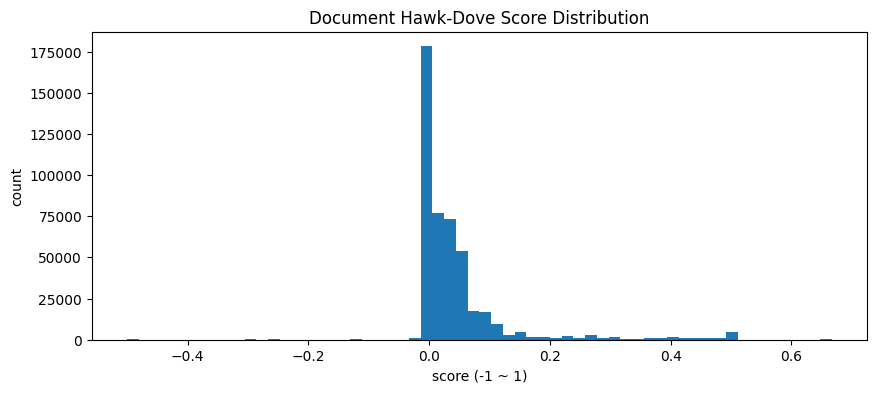

score describe
count    462053.000000
mean          0.043349
std           0.087785
min          -0.500000
25%           0.000026
50%           0.017274
75%           0.048674
max           0.666667
Name: doc_hawk_dove_score_prob, dtype: float64

===== TOP docs (hawkish side) =====
 doc_hawk_dove_score_prob  topic_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text_for_topic
                 0.666667         6                                                                                                                                                      

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# 0) df_keep 로딩/확인
# =========================
# 이미 df_keep가 있으면 그대로 쓰고, 없으면 저장파일에서 로드
try:
    df_keep
except NameError:
    df_keep = pd.read_csv('df_topic_scored_prob_fast.csv')

score_col = 'doc_hawk_dove_score_prob'
text_col = 'text_for_topic' if 'text_for_topic' in df_keep.columns else (
    'cleaned_text_lemma' if 'cleaned_text_lemma' in df_keep.columns else 'cleaned_text'
)

need_cols = [score_col, 'topic_id', text_col]
for c in need_cols:
    if c not in df_keep.columns:
        raise ValueError(c + ' 컬럼이 없습니다. df_keep.columns 확인 필요')

# =========================
# 1) 점수 분포(히스토그램)
# =========================
vals = df_keep[score_col].astype(float).fillna(0.0).values

plt.figure(figsize=(10, 4))
plt.hist(vals, bins=60)
plt.title('Document Hawk-Dove Score Distribution')
plt.xlabel('score (-1 ~ 1)')
plt.ylabel('count')
plt.show()

print('score describe')
print(df_keep[score_col].describe())

# =========================
# 2) 상/하위 문서 샘플 확인
# =========================
TOPK = 20

df_sorted = df_keep.sort_values(score_col, ascending=False)

top_docs = df_sorted.head(TOPK)[[score_col, 'topic_id', text_col]].copy()
bot_docs = df_sorted.tail(TOPK)[[score_col, 'topic_id', text_col]].copy()

print('\n===== TOP docs (hawkish side) =====')
print(top_docs.to_string(index=False))

print('\n===== BOTTOM docs (dovish side) =====')
print(bot_docs.to_string(index=False))

In [32]:
import numpy as np
import pandas as pd

# =========================
# 0) topic_model 존재 체크
# =========================
try:
    topic_model
except NameError:
    raise ValueError("topic_model이 현재 세션에 없습니다. (토픽 단어를 뽑으려면 topic_model 객체가 필요)")

# =========================
# 1) topic_id별 요약(문서 수/평균 점수)
# =========================
score_col = 'doc_hawk_dove_score_prob'

topic_stats = (
    df_keep.groupby('topic_id')[score_col]
    .agg(['count', 'mean', 'median'])
    .reset_index()
    .rename(columns={'count': 'doc_count', 'mean': 'score_mean', 'median': 'score_median'})
)

# =========================
# 2) topic_id별 top words 추출
# =========================
def get_top_words(tid, topn=15):
    if tid == -1:
        return ""
    ws = topic_model.get_topic(int(tid))
    if not ws:
        return ""
    return ", ".join([w for w, _ in ws[:topn]])

topic_stats['top_words'] = topic_stats['topic_id'].apply(lambda x: get_top_words(x, topn=15))

# =========================
# 3) 라벨링 룰 (임계값은 너가 조정)
#   - mean이 +0.15 이상: hawkish
#   - mean이 -0.15 이하: dovish
#   - 그 외: neutral
# =========================
TH = 0.15
def label_topic(x):
    if x >= TH:
        return 'hawkish'
    if x <= -TH:
        return 'dovish'
    return 'neutral'

topic_stats['topic_label'] = topic_stats['score_mean'].apply(label_topic)

# 보기 좋게 정렬
topic_stats = topic_stats.sort_values(['topic_label', 'score_mean'], ascending=[True, False])

print('\n===== Topic label table =====')
print(topic_stats[['topic_id', 'topic_label', 'doc_count', 'score_mean', 'score_median', 'top_words']].to_string(index=False))

# 저장
topic_stats.to_csv('topic_label_table.csv', index=False)
print('\nsaved : topic_label_table.csv')


===== Topic label table =====
 topic_id topic_label  doc_count  score_mean  score_median                                                                                top_words
        5     hawkish       3068    0.297660      0.337222             trump, meet, say, end, potential, energy, infrastructure, fuel, follow, warn
        1     hawkish      20225    0.259311      0.217632                    trade, future, demand, year, rise, billion, high, week, price, august
       10     neutral        269    0.114715      0.075273 air, condition, activity, price, additionally, manufacturing, mark, decline, 10, service
       11     neutral        490    0.110887      0.123724 infrastructure, october, demand, expect, country, stay, condition, ahead, follow, august
        6     neutral       5903    0.100958      0.016209                  new, trump, follow, face, concern, say, pressure, policy, country, late
       -1     neutral     288506    0.032537      0.007111                       

In [33]:
TH = 0.05  # 필요하면 0.03 ~ 0.08 사이에서 조정

def classify_doc(score, th=TH):
    if score >= th:
        return "hawkish"
    elif score <= -th:
        return "dovish"
    else:
        return "neutral"

In [34]:
df_keep['doc_policy_label'] = df_keep['doc_hawk_dove_score_prob'].apply(classify_doc)

In [35]:
df_keep['doc_policy_label'].value_counts(normalize=True).round(4)

,proportion
doc_policy_label,
neutral,0.7566
hawkish,0.2402
dovish,0.0032


In [36]:
required_cols = ['text_for_topic', 'topic_id', 'doc_hawk_dove_score_prob']
for c in required_cols:
    if c not in df_keep.columns:
        raise ValueError(f"필수 컬럼 누락: {c}")

In [37]:
df_keep['doc_hawk_dove_score_prob'].describe()

,doc_hawk_dove_score_prob
count,462053.000000
mean,0.043349
std,0.087785
min,-0.500000
25%,0.000026
50%,0.017274
75%,0.048674
max,0.666667


In [38]:
TH = 0.05  # 임계값 (너 데이터 기준 최적)

def classify_doc(score, th=TH):
    if score >= th:
        return "hawkish"
    elif score <= -th:
        return "dovish"
    else:
        return "neutral"

df_keep['doc_policy_label'] = df_keep['doc_hawk_dove_score_prob'].apply(classify_doc)

In [39]:
print("===== Document label distribution =====")
print(
    df_keep['doc_policy_label']
    .value_counts(normalize=True)
    .round(4)
)

===== Document label distribution =====
doc_policy_label
neutral    0.7566
hawkish    0.2402
dovish     0.0032
Name: proportion, dtype: float64


In [40]:
topic_summary = (
    df_keep.groupby('topic_id')['doc_hawk_dove_score_prob']
    .agg(['count', 'mean', 'median'])
    .reset_index()
    .rename(columns={
        'count': 'doc_count',
        'mean': 'score_mean',
        'median': 'score_median'
    })
)

def label_topic(x):
    if x >= TH:
        return 'hawkish'
    elif x <= -TH:
        return 'dovish'
    else:
        return 'neutral'

topic_summary['topic_label'] = topic_summary['score_mean'].apply(label_topic)

topic_summary = topic_summary.sort_values(
    ['topic_label', 'score_mean'],
    ascending=[True, False]
)

print("\n===== Topic label table =====")
print(topic_summary.to_string(index=False))


===== Topic label table =====
 topic_id  doc_count  score_mean  score_median topic_label
        7       2200   -0.122078      0.017994      dovish
        5       3068    0.297660      0.337222     hawkish
        1      20225    0.259311      0.217632     hawkish
       10        269    0.114715      0.075273     hawkish
       11        490    0.110887      0.123724     hawkish
        6       5903    0.100958      0.016209     hawkish
       -1     288506    0.032537      0.007111     neutral
        0     119277    0.030031      0.032753     neutral
       12        102    0.025998      0.008650     neutral
        4       4740    0.025136      0.022438     neutral
        9       1961    0.023658      0.018822     neutral
        3       5514    0.023426      0.024817     neutral
        2       9367    0.020170      0.012147     neutral
        8        424    0.008691      0.003522     neutral
       13          7    0.000231      0.000000     neutral


In [41]:
df_keep.to_csv('df_doc_policy_label.csv', index=False)
topic_summary.to_csv('topic_label_table.csv', index=False)

print("saved : df_doc_policy_label.csv")
print("saved : topic_label_table.csv")

saved : df_doc_policy_label.csv
saved : topic_label_table.csv


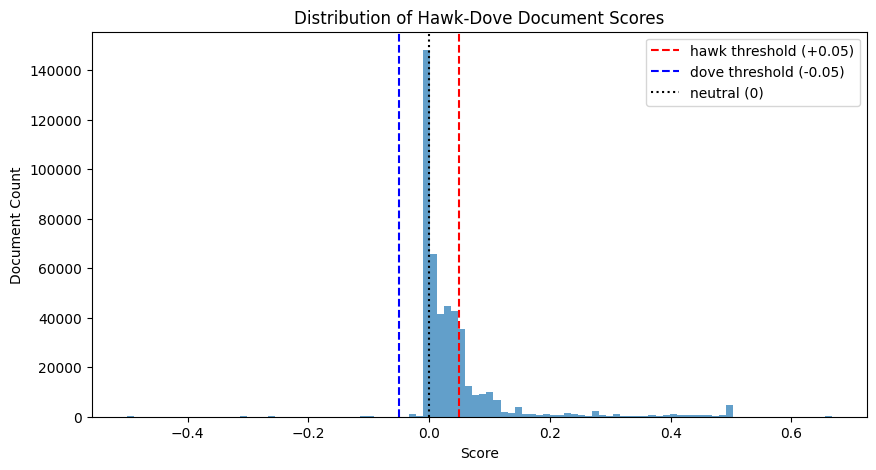

In [42]:
import matplotlib.pyplot as plt

score_col = 'doc_hawk_dove_score_prob'

plt.figure(figsize=(10, 5))
plt.hist(df_keep[score_col], bins=100, alpha=0.7)
plt.axvline(0.05, color='red', linestyle='--', label='hawk threshold (+0.05)')
plt.axvline(-0.05, color='blue', linestyle='--', label='dove threshold (-0.05)')
plt.axvline(0, color='black', linestyle=':', label='neutral (0)')
plt.title('Distribution of Hawk-Dove Document Scores')
plt.xlabel('Score')
plt.ylabel('Document Count')
plt.legend()
plt.show()

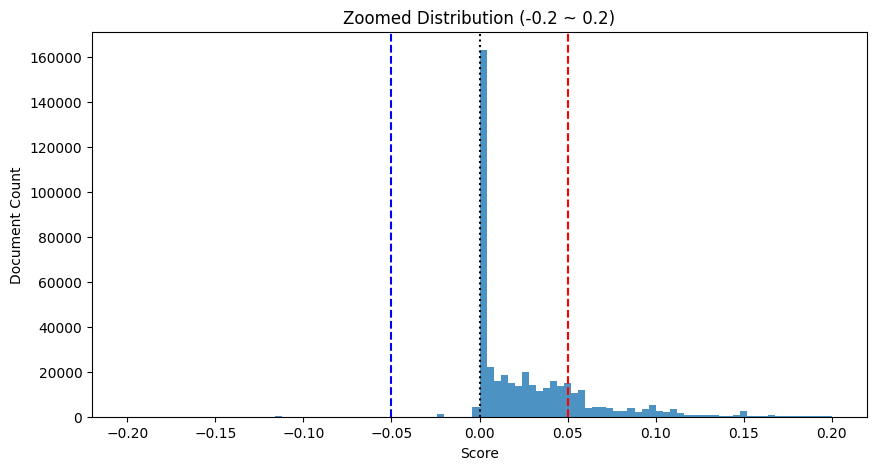

In [43]:
plt.figure(figsize=(10, 5))
plt.hist(
    df_keep[score_col],
    bins=100,
    range=(-0.2, 0.2),
    alpha=0.8
)
plt.axvline(0.05, color='red', linestyle='--')
plt.axvline(-0.05, color='blue', linestyle='--')
plt.axvline(0, color='black', linestyle=':')
plt.title('Zoomed Distribution (-0.2 ~ 0.2)')
plt.xlabel('Score')
plt.ylabel('Document Count')
plt.show()

In [44]:
def label_doc(score, th=0.05):
    if score >= th:
        return 'hawkish'
    if score <= -th:
        return 'dovish'
    return 'neutral'

df_keep['doc_label'] = df_keep[score_col].apply(label_doc)

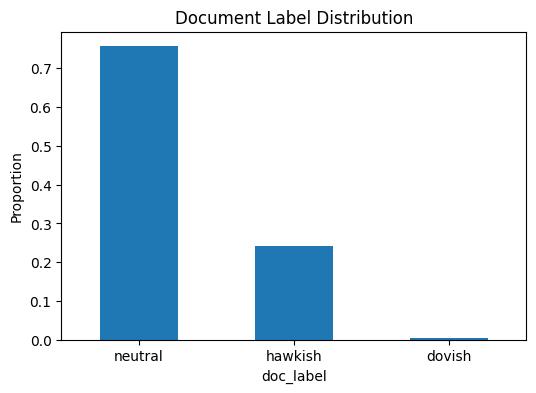

,proportion
doc_label,
neutral,0.756632
hawkish,0.240152
dovish,0.003216


In [45]:
label_counts = df_keep['doc_label'].value_counts(normalize=True)

plt.figure(figsize=(6, 4))
label_counts.plot(kind='bar')
plt.title('Document Label Distribution')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.show()

label_counts

In [46]:
df_keep.sort_values(score_col, ascending=False).head(10)[
    [score_col, 'topic_id', 'text_for_topic']
]

df_keep.sort_values(score_col).head(10)[
    [score_col, 'topic_id', 'text_for_topic']
]

,doc_hawk_dove_score_prob,topic_id,text_for_topic
155661,-0.5,7,terrorism insurance be reject in the senate wa...
151500,-0.5,7,senate approves stopgap budget
151502,-0.5,7,the senate on thursday approve and send to pre...
140783,-0.5,7,more democrat say they would have vote for the...
19136,-0.5,7,bill pass 148 vote favor 200 senator clear hou...
152614,-0.5,7,republican senator propose medicare change fou...
152595,-0.5,7,the senate easily approve a two year 109 billi...
1351,-0.5,7,shutdown entered seventh day democratic republ...
153488,-0.5,7,the senate on thursday fail to clear a bill th...
3245,-0.5,7,closure also trigger data blackout force labor...


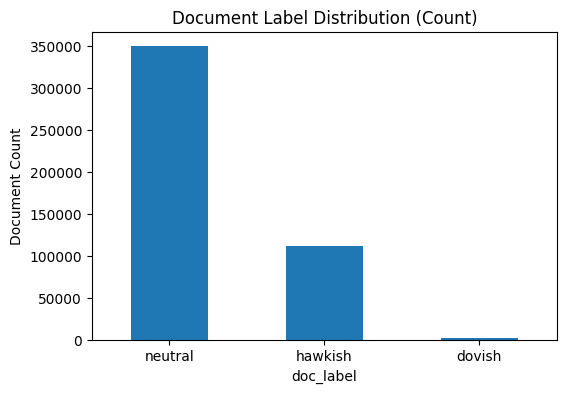

,count
doc_label,
neutral,349604
hawkish,110963
dovish,1486


In [47]:
import matplotlib.pyplot as plt

label_counts_cnt = df_keep['doc_label'].value_counts()  # normalize=False (기본값)

plt.figure(figsize=(6, 4))
label_counts_cnt.plot(kind='bar')
plt.title('Document Label Distribution (Count)')
plt.ylabel('Document Count')
plt.xlabel('doc_label')
plt.xticks(rotation=0)
plt.show()

label_counts_cnt


In [48]:
pd.DataFrame({
    'count': label_counts_cnt,
    'proportion': label_counts_cnt / label_counts_cnt.sum()
})

,count,proportion
doc_label,,
neutral,349604,0.756632
hawkish,110963,0.240152
dovish,1486,0.003216


In [56]:
def label_doc_asymmetric(score):
    if score >= 0.05:
        return 'hawkish'
    elif score <= -0.02:
        return 'dovish'
    else:
        return 'neutral'

df_keep['doc_label'] = df_keep['doc_hawk_dove_score_prob'].apply(label_doc_asymmetric)

In [57]:
df_keep['doc_label'].value_counts(), df_keep['doc_label'].value_counts(normalize=True)

(doc_label
 neutral    348307
 hawkish    110963
 dovish       2783
 Name: count, dtype: int64,
 doc_label
 neutral    0.753825
 hawkish    0.240152
 dovish     0.006023
 Name: proportion, dtype: float64)

In [58]:
df_keep.shape[1]

11

In [59]:
df_keep.columns.tolist()

['doc_id',
 'cleaned_text',
 'tf_idf_over0.5',
 'tf_idf_top50',
 'distilled_by_collocation',
 'cleaned_text_lemma',
 'text_for_topic',
 'topic_id',
 'doc_hawk_dove_score_prob',
 'doc_policy_label',
 'doc_label']

In [60]:
keep_cols = [
    'doc_id',                     # 문서 식별자
    'cleaned_text_lemma',          # 전처리된 원문
    'text_for_topic',              # collocation 반영 텍스트
    'topic_id',                    # BERTopic 결과
    'doc_hawk_dove_score_prob',    # 확률 기반 매/비 점수 (-1~1)
    'doc_label'                    # hawkish / dovish / neutral
]

In [61]:
df_final = df_keep[keep_cols].copy()

In [62]:
print('final columns:', df_final.columns.tolist())
print('shape:', df_final.shape)
df_final.head()

final columns: ['doc_id', 'cleaned_text_lemma', 'text_for_topic', 'topic_id', 'doc_hawk_dove_score_prob', 'doc_label']
shape: (462053, 6)


,doc_id,cleaned_text_lemma,text_for_topic,topic_id,doc_hawk_dove_score_prob,doc_label
0,bond_report_20251009 13:04,yield u 10-year treasury note edge 4.14 thursd...,yield u 10-year treasury note edge 4.14 thursd...,0,0.023252,neutral
1,bond_report_20251009 13:04,trader remain cautious await fresh catalyst ti...,trader remain cautious await fresh catalyst ti...,-1,0.005021,neutral
2,bond_report_20251009 13:04,market continue price two additional 25-basis-...,market continue price two additional 25-basis-...,-1,0.000410,neutral
3,bond_report_20251009 13:04,wednesday senate reject funding proposal repub...,wednesday senate reject funding proposal repub...,7,0.021780,neutral
4,bond_report_20251009 13:04,meanwhile treasury department ’ auction 10-yea...,meanwhile treasury department ’ auction 10-yea...,0,0.018927,neutral


In [63]:
df_final.to_csv(
    'df_final_hawk_dove_topic_prob.csv',
    index=False
)

print('saved : df_final_hawk_dove_topic_prob.csv')

saved : df_final_hawk_dove_topic_prob.csv


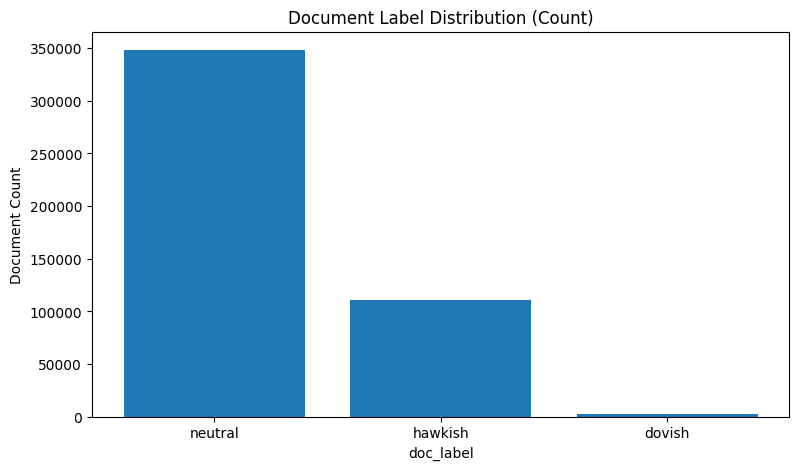

count


,count
doc_label,
neutral,348307
hawkish,110963
dovish,2783


In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# df_keep에 doc_label 컬럼이 있다고 가정
# (없으면: df_keep['doc_label'] = ... 라벨링 먼저)

# 1) count 계산
counts = df_keep['doc_label'].value_counts()

# 2) 막대그래프 (y=개수)
plt.figure(figsize=(9, 5))
plt.bar(counts.index, counts.values)
plt.title('Document Label Distribution (Count)')
plt.xlabel('doc_label')
plt.ylabel('Document Count')
plt.show()

# 3) 표로 출력 (스크린샷처럼 "count" 헤더 형태)
print('count')
display(counts.to_frame())